# YZV311E Data Mining Project Data Preprocessing and Exploration
__________

### Hasan Taha Bağcı - 150210338
### Selman Turan Toker - 150220330
____________

In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils.data_preprocess import *
from utils.plots import *

import warnings
warnings.filterwarnings('ignore')


from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

## Reading the Data and Exploring Main Features

In [69]:
product_catalog = pd.read_csv('data/product_catalog.csv')
product_category_map = pd.read_csv('data/product_category_map.csv')
transactions = pd.read_csv('data/transactions.csv')
test = pd.read_csv('data/test2.csv')

Shapes of the datasets are printed below.

In [70]:
print('product_catalog:', product_catalog.shape)
print('product_category_map:', product_category_map.shape)
print('transactions:', transactions.shape)


product_catalog: (32776, 8)
product_category_map: (4332, 2)
transactions: (1071538, 4)


In [71]:
final = transactions.merge(product_catalog, on='product_id', how='left')

In [72]:
final.head()

,customer_id,product_id,purchase_date,quantity,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,categories
0,38769,3477,2020-06-01,1,186,6,0,196,0,45,"[74, 4109, 3867, 803, 4053]"
1,42535,30474,2020-06-01,1,193,10,3,229,3,132,"[3459, 3738, 679, 1628, 4072]"
2,42535,15833,2020-06-01,1,1318,4,1,455,0,108,"[2973, 2907, 2749, 3357]"
3,42535,20131,2020-06-01,1,347,4,0,291,3,44,"[30, 1515, 1760, 2932, 1287, 2615, 3727, 2450,..."
4,42535,4325,2020-06-01,1,539,6,0,303,0,45,"[3104, 1772, 2029, 1274, 3915, 888, 1118, 3882..."


In [73]:

import ast

# Create a mapping from category_id to parent_category_id
category_to_parent = product_category_map.set_index('category_id')['parent_category_id'].to_dict()

# Function to map categories to their parent categories
def get_parent_categories(categories_str):
    if pd.isna(categories_str) or categories_str == '':
        return []
    # Convert string representation of list to an actual list
    categories = ast.literal_eval(categories_str)
    # Map each category to its parent
    parent_categories = [category_to_parent.get(cat_id, None) for cat_id in categories]
    # Remove None values if any category_id doesn't have a parent in the map
    return [parent for parent in parent_categories if parent is not None]

# Apply the function to add the parent_categories column
final['parent_categories'] = final['categories'].apply(get_parent_categories)

In [74]:
final_nulls_removed = final.dropna()
final_nulls_removed.isnull().sum()

customer_id          0
product_id           0
purchase_date        0
quantity             0
manufacturer_id      0
attribute_1          0
attribute_2          0
attribute_3          0
attribute_4          0
attribute_5          0
categories           0
parent_categories    0
dtype: int64

In [75]:

def fill_missing_category(row):
    if pd.isna(row['categories']):
        return row['parent_categories']
    return row['categories']



In [76]:

final["categories"] = final.apply(fill_missing_category, axis=1)
final_nulls_filled = final

In [77]:
# Get ready for the model split the data into train and test
final_nulls_filled['purchase_date'] = pd.to_datetime(final_nulls_filled['purchase_date'])

# Get the latest purchase date
latest_date = final_nulls_filled['purchase_date'].max()

# Calculate the days since purchase of each purchase
final_nulls_filled['days_since_purchase'] = latest_date - final_nulls_filled['purchase_date']

# Convert days since purchase to days
final_nulls_filled['days_since_purchase'] = final_nulls_filled['days_since_purchase'].dt.days



# Get the total number of purchases for each user
#final_nulls_filled['total_purchases'] = final_nulls_filled.groupby('customer_id')['customer_id'].transform('count')

# Get the total number of unique products purchased by each user
#final_nulls_filled['unique_products'] = final_nulls_filled.groupby('customer_id')['product_id'].transform('nunique')

In [78]:
final_nulls_filled_sorted = final_nulls_filled.sort_values(by=['customer_id', 'product_id'])
final_nulls_filled_sorted.head(100)
final_nulls_filled_sorted["total_product_sold"] = final_nulls_filled_sorted.groupby(['customer_id','product_id'])['quantity'].transform('sum')
final_nulls_filled_sorted.head(100)
final_nulls_filled_sorted['last_purchase'] = final_nulls_filled_sorted.groupby(['customer_id', 'product_id'])['days_since_purchase'].transform('min')
final_nulls_filled_sorted=final_nulls_filled_sorted.reset_index(drop=True)
final_nulls_filled_sorted.head(15)







,customer_id,product_id,purchase_date,quantity,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,categories,parent_categories,days_since_purchase,total_product_sold,last_purchase
0,0,1505,2020-09-01,1,286,4,0,82,0,144,"[3392, 179, 1390, 563, 383, 1886]","[1374, 1062, 2762, 1666, 3439, 1062]",152,1,152
1,0,6446,2020-12-11,1,839,4,0,18,0,81,"[545, 1032, 3963]","[2012, 2924, 3898]",51,2,16
2,0,6446,2021-01-15,1,839,4,0,18,0,81,"[545, 1032, 3963]","[2012, 2924, 3898]",16,2,16
3,0,9325,2020-11-20,1,107,6,0,308,3,17,"[3024, 1772, 1136, 3882, 948, 4071]","[1682, 1682, 452, 264, 264, 3898]",72,1,72
4,0,12468,2020-08-03,1,1288,10,0,421,3,3,"[3224, 2690, 2700]","[2385, 1841, 1841]",181,1,181
5,0,12505,2020-08-18,1,53,4,3,474,0,-1,"[1073, 3529, 3005, 3574, 1760, 3436, 1472, 226...","[600, 298, 366, 366, 2762, 600, 600, 2771, 600...",166,1,166
6,0,13146,2021-01-25,2,193,4,0,453,-1,108,"[3900, 3901, 3902, 3903, 3910, 3855, 3254, 137...","[3898, 3898, 3898, 3898, 3898, 2824, 100, 1223...",6,2,6
7,0,15083,2020-08-03,1,286,4,0,82,0,144,"[3392, 179, 1390, 563, 383, 1886, 3912, 1763, ...","[1374, 1062, 2762, 1666, 3439, 1062, 3898, 389...",181,1,181
8,0,20664,2020-06-05,1,408,4,0,284,0,66,"[236, 356]","[2054, 1303]",240,3,51
9,0,20664,2020-10-09,1,408,4,0,284,0,66,"[236, 356]","[2054, 1303]",114,3,51


In [79]:


recency_diff = final_nulls_filled_sorted.groupby(['customer_id', 'product_id']).agg(
    max_date=('days_since_purchase', 'max'),
    min_date=('days_since_purchase', 'min'),
    total_product_sold=('total_product_sold', 'first')
)

# 
recency_diff['recency_div_product'] = (recency_diff['max_date'] - recency_diff['min_date']) / (recency_diff['total_product_sold']) #+1 gelmesi lazım sona

# Ana DataFrame'e merge ederek ekle
final_nulls_filled_sorted = final_nulls_filled_sorted.merge(recency_diff['recency_div_product'].reset_index(), on=['customer_id', 'product_id'], how='left')
final_nulls_filled_sorted['recency_div_product'] = final_nulls_filled_sorted.apply(
    lambda row: int(row['days_since_purchase']) if row['recency_div_product'] == 0 else int(row['recency_div_product']), 
    axis=1
)

# Sonuçları gösterelim
final_nulls_filled_sorted.head(15)


,customer_id,product_id,purchase_date,quantity,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,categories,parent_categories,days_since_purchase,total_product_sold,last_purchase,recency_div_product
0,0,1505,2020-09-01,1,286,4,0,82,0,144,"[3392, 179, 1390, 563, 383, 1886]","[1374, 1062, 2762, 1666, 3439, 1062]",152,1,152,152
1,0,6446,2020-12-11,1,839,4,0,18,0,81,"[545, 1032, 3963]","[2012, 2924, 3898]",51,2,16,17
2,0,6446,2021-01-15,1,839,4,0,18,0,81,"[545, 1032, 3963]","[2012, 2924, 3898]",16,2,16,17
3,0,9325,2020-11-20,1,107,6,0,308,3,17,"[3024, 1772, 1136, 3882, 948, 4071]","[1682, 1682, 452, 264, 264, 3898]",72,1,72,72
4,0,12468,2020-08-03,1,1288,10,0,421,3,3,"[3224, 2690, 2700]","[2385, 1841, 1841]",181,1,181,181
5,0,12505,2020-08-18,1,53,4,3,474,0,-1,"[1073, 3529, 3005, 3574, 1760, 3436, 1472, 226...","[600, 298, 366, 366, 2762, 600, 600, 2771, 600...",166,1,166,166
6,0,13146,2021-01-25,2,193,4,0,453,-1,108,"[3900, 3901, 3902, 3903, 3910, 3855, 3254, 137...","[3898, 3898, 3898, 3898, 3898, 2824, 100, 1223...",6,2,6,6
7,0,15083,2020-08-03,1,286,4,0,82,0,144,"[3392, 179, 1390, 563, 383, 1886, 3912, 1763, ...","[1374, 1062, 2762, 1666, 3439, 1062, 3898, 389...",181,1,181,181
8,0,20664,2020-06-05,1,408,4,0,284,0,66,"[236, 356]","[2054, 1303]",240,3,51,63
9,0,20664,2020-10-09,1,408,4,0,284,0,66,"[236, 356]","[2054, 1303]",114,3,51,63


In [89]:
# Satın alımları müşteri ve ürün bazında sıralayalım
final_nulls_filled_sorted = final_nulls_filled_sorted.sort_values(by=['customer_id', 'product_id', 'purchase_date'])

# Bir sonraki satın alım tarihini bulalım
final_nulls_filled_sorted['next_purchase_date'] = final_nulls_filled_sorted.groupby(['customer_id', 'product_id'])['purchase_date'].shift(-1)

# Satın alım gün farkını hesaplayalım
final_nulls_filled_sorted['next_purchase_days'] = (final_nulls_filled_sorted['next_purchase_date'] - final_nulls_filled_sorted['purchase_date']).dt.days

# Günleri haftalara çevirelim
final_nulls_filled_sorted['next_purchase_weeks'] = final_nulls_filled_sorted['next_purchase_days'].apply(
    lambda x: 0 if pd.isna(x) else (x // 7) + 1  # 4 haftadan büyükse veya sonraki satın alım yoksa 0//// 0 7 14 değerlerini kontrol et
)

# Satırları sıfırlayalım
final_nulls_filled_sorted['next_purchase_days'] = final_nulls_filled_sorted['next_purchase_days'].fillna(0).astype(int)
final_nulls_filled_sorted['next_purchase_weeks'] = final_nulls_filled_sorted['next_purchase_weeks'].astype(int)

# Sonuçları gösterelim
final_nulls_filled_sorted[['customer_id', 'product_id', 'purchase_date', 'next_purchase_days', 'next_purchase_weeks']].head(20)


,customer_id,product_id,purchase_date,next_purchase_days,next_purchase_weeks
0,0,1505,2020-09-01,0,0
1,0,6446,2020-12-11,35,6
2,0,6446,2021-01-15,0,0
3,0,9325,2020-11-20,0,0
4,0,12468,2020-08-03,0,0
5,0,12505,2020-08-18,0,0
6,0,13146,2021-01-25,0,0
7,0,15083,2020-08-03,0,0
8,0,20664,2020-06-05,126,19
9,0,20664,2020-10-09,63,10


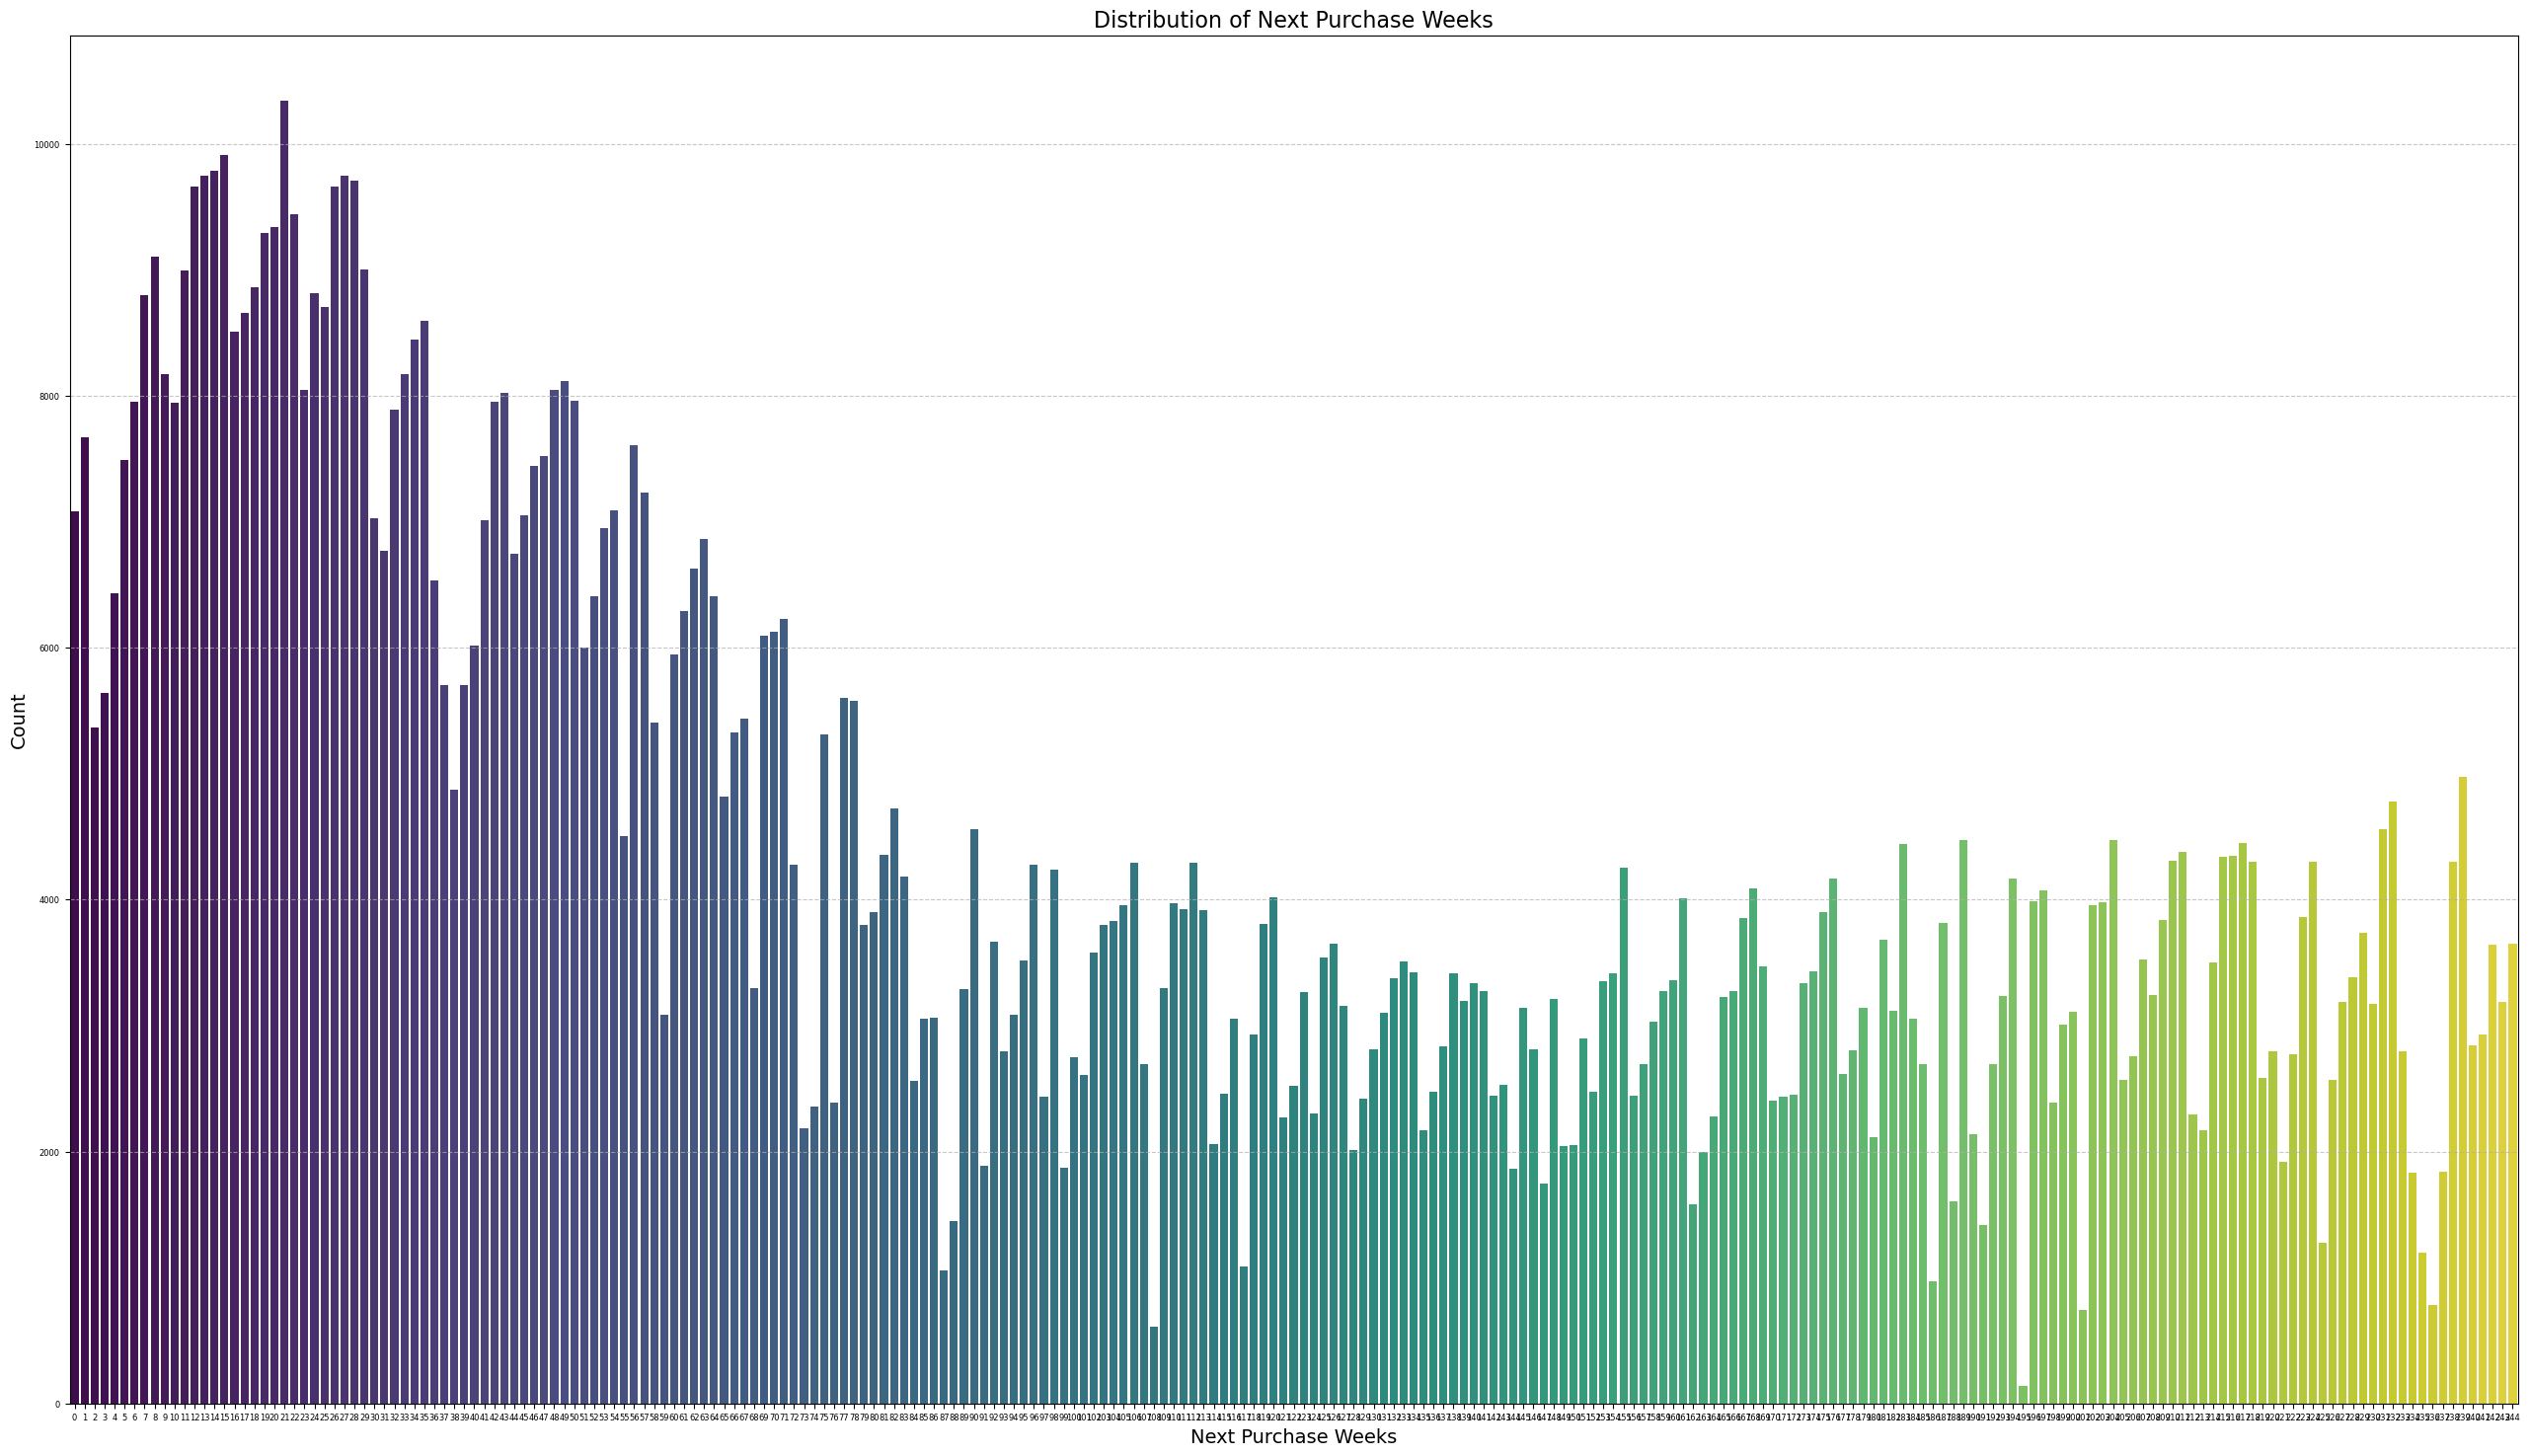

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dağılım grafiği
plt.figure(figsize=(32, 18))
sns.countplot(x='recency_div_product', data=final_nulls_filled_sorted, palette="viridis")

# Grafik detayları
plt.title('Distribution of Next Purchase Weeks', fontsize=16)
plt.xlabel('Next Purchase Weeks', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [81]:
#we don't need date data anymore because we have recency data
final_nulls_filled_date_droped =final_nulls_filled_sorted.drop(["purchase_date"],axis=1)
final_nulls_filled_date_droped2 =final_nulls_filled_sorted.drop(["purchase_date","categories","parent_categories"],axis=1)


In [82]:
final_nulls_filled_date_droped.head()




,customer_id,product_id,quantity,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,categories,parent_categories,days_since_purchase,last_purchase,recency_div_product
0,0,1505,1,286,4,0,82,0,144,"[3392, 179, 1390, 563, 383, 1886]","[1374, 1062, 2762, 1666, 3439, 1062]",152,152,152
1,0,6446,1,839,4,0,18,0,81,"[545, 1032, 3963]","[2012, 2924, 3898]",51,16,17
2,0,6446,1,839,4,0,18,0,81,"[545, 1032, 3963]","[2012, 2924, 3898]",16,16,17
3,0,9325,1,107,6,0,308,3,17,"[3024, 1772, 1136, 3882, 948, 4071]","[1682, 1682, 452, 264, 264, 3898]",72,72,72
4,0,12468,1,1288,10,0,421,3,3,"[3224, 2690, 2700]","[2385, 1841, 1841]",181,181,181


In [83]:

print(final_nulls_filled_date_droped.columns)
print(final_nulls_filled_date_droped.shape)


Index(['customer_id', 'product_id', 'quantity', 'manufacturer_id',
       'attribute_1', 'attribute_2', 'attribute_3', 'attribute_4',
       'attribute_5', 'categories', 'parent_categories', 'days_since_purchase',
       'last_purchase', 'recency_div_product'],
      dtype='object')
(1071538, 14)


In [84]:
final_nulls_filled_date_droped2.columns

Index(['customer_id', 'product_id', 'quantity', 'manufacturer_id',
       'attribute_1', 'attribute_2', 'attribute_3', 'attribute_4',
       'attribute_5', 'days_since_purchase', 'last_purchase',
       'recency_div_product'],
      dtype='object')

In [85]:
X = final_nulls_filled_date_droped2.drop(["recency",'last_purchase'],axis=1)

y = final_nulls_filled_date_droped2['recency']  # Bu örnekte 'recency' hedef değişken olarak kullanılıyor


KeyError: "['recency'] not found in axis"

In [21]:
from sklearn.model_selection import train_test_split

# Eğitim ve test setlerini ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score  
import numpy as np

# 4. Random Forest Modeli
model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
model.fit(X_train, y_train)

# 5. Önemli özellikleri seçme
selector = SelectFromModel(model, threshold=0.001, prefit=True)  # 0.001 eşiği ayarlanabilir
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

print(f"Seçilen özellik sayısı: {X_train_selected.shape[1]}")

# 6. Modeli yeniden eğitme (sadece önemli özellikler)
model.fit(X_train_selected, y_train)

# 7. Tahmin yapma
y_pred = model.predict(X_test_selected)


# 8. Performansı ölçme
accuracy = accuracy_score(y_test, y_pred)
print(f"Yeni doğruluk skoru: {accuracy:.5f}")

# Modeli ve ilgili objeleri kaydetme
import joblib
joblib.dump(model, 'rf_model.pkl')
joblib.dump(selector, 'feature_selector.pkl')


KeyboardInterrupt: 

In [ ]:
test_data = test
final_unique = final_nulls_filled_date_droped2.drop_duplicates(subset=['customer_id', 'product_id'])

test_data_merged = pd.merge(test_data,final_unique[['customer_id', 'product_id', 'quantity', 'manufacturer_id',
       'attribute_1', 'attribute_2', 'attribute_3', 'attribute_4',
       'attribute_5', 'last_purchase', 'recency_diff_div_total']], on=['customer_id','product_id'],how='left')


test_data_reduced = test_data_merged.drop_duplicates(subset=['customer_id', 'product_id'])
final_test=test_data_reduced.copy()
print(final_test.columns)
test_data_reduced.drop(columns=['id','prediction','last_purchase'],inplace=True)


Index(['id', 'customer_id', 'product_id', 'prediction', 'quantity',
       'manufacturer_id', 'attribute_1', 'attribute_2', 'attribute_3',
       'attribute_4', 'attribute_5', 'last_purchase',
       'recency_diff_div_total'],
      dtype='object')


In [25]:
final_test.columns

Index(['id', 'customer_id', 'product_id', 'prediction', 'quantity',
       'manufacturer_id', 'attribute_1', 'attribute_2', 'attribute_3',
       'attribute_4', 'attribute_5', 'last_purchase',
       'recency_diff_div_total'],
      dtype='object')

In [ ]:
# Eğitim sırasında kullanılan sütunların indekslerini al
selected_indices = feature_selector.get_support(indices=True)
# Eğitim sırasında kullanılan sütun isimlerini al
selected_columns = test_data_reduced.columns[selected_indices]
print("Eğitimde Kullanılan Sütun Sayısı:", len(selected_columns))
print("Eğitimde Kullanılan Sütunlar:", selected_columns)


NameError: name 'feature_selector' is not defined

In [ ]:
# Test verisini eğitim sırasında kullanılan sütunlara göre düzenle
test_data_selected = test_data_reduced.reindex(columns=selected_columns, fill_value=0)
print("Test Verisinin Boyutu:", test_data_reduced.columns)


NameError: name 'selected_columns' is not defined

In [ ]:
# Feature selector'ı test verisine uygulayın
X_test_selected = feature_selector.transform(test_data_reduced)

# Test verisinin boyutunu kontrol edin
print("Dönüştürülmüş Test Verisinin Boyutu:", X_test_selected.shape)


NameError: name 'feature_selector' is not defined

In [ ]:
import joblib

# Eğitilen modeli ve feature selector'ı yükleyin
model = joblib.load('rf_model.pkl')
feature_selector = joblib.load('feature_selector.pkl')


# Eğitim sırasında kullanılan sütunları al
train_columns = feature_selector.get_support(indices=True)

# Test verisini aynı sütun sıralamasına göre yeniden düzenle
test_data_selected = test_data_reduced.iloc[:, train_columns]

# Özellik seçiciyi test verisine uygulayın
X_test_selected = feature_selector.transform(test_data_selected)

# Model ile tahmin yapın
y_pred = model.predict(X_test_selected)

# Sonuçları göster
print(y_pred)











# Gerekirse bir CSV'ye yazma örneği (id sütunu ile birleştirerek):
test_data_reduced['prediction'] = y_pred
# test_df.to_csv('test_predictions.csv', index=False)


[ 8  8 24 ...  2 10  5]


In [ ]:
final_test['prediction'] = y_pred


In [31]:
test_data_reduced.head()

,customer_id,product_id,quantity,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,recency_diff_div_total,prediction
0,0,20664,1,408,4,0,284,0,66,9,8
1,0,28231,1,193,4,3,468,3,108,2,8
2,13,2690,1,406,4,3,491,0,66,7,24
3,15,1299,1,1056,4,0,474,-1,108,4,10
4,15,20968,1,1315,4,0,444,0,144,4,10


In [ ]:
final_test.head(18)

,id,customer_id,product_id,prediction,quantity,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,last_purchase,recency_diff_div_total
0,0,0,20664,8,1,408,4,0,284,0,66,8,9
1,1,0,28231,8,1,193,4,3,468,3,108,1,2
2,2,13,2690,24,1,406,4,3,491,0,66,6,7
3,3,15,1299,10,1,1056,4,0,474,-1,108,3,4
4,4,15,20968,10,1,1315,4,0,444,0,144,1,4
5,5,20,8272,9,1,783,10,1,503,3,17,14,5
6,6,24,11340,8,2,406,10,0,504,0,17,6,4
7,7,34,21146,3,1,325,4,0,267,0,78,12,5
8,8,34,31244,3,1,1093,4,0,491,0,66,3,7
9,9,46,31083,4,1,643,10,0,124,3,83,4,8


In [35]:
import pandas as pd

# Test CSV'sinin orijinal hali
test_original = pd.read_csv('data/test.csv')

# Yeni prediction değerlerini hesapla
final_test['new_prediction'] = final_test.apply(
    lambda row: (
        1 if (row['prediction'] - row['last_purchase']) <= 0 else
        row['prediction'] - row['last_purchase'] if 1 <= (row['prediction'] - row['last_purchase']) <= 4 else
        0
    ),
    axis=1
)

# Güncellenmiş prediction değerlerini test_original'a ekle
test_original['prediction'] = final_test['new_prediction']

# Güncellenmiş CSV'yi kaydet
test_original.to_csv('updatedt_test_predictions.csv', index=False)

print("Güncellenmiş test dosyası başarıyla kaydedildi: updated_test_predictions.csv")


Güncellenmiş test dosyası başarıyla kaydedildi: updated_test_predictions.csv


In [36]:
final_test[['prediction','last_purchase','recency_diff_div_total','new_prediction']].head(18)

,prediction,last_purchase,recency_diff_div_total,new_prediction
0,8,8,9,1
1,8,1,2,1
2,24,6,7,1
3,10,3,4,1
4,10,1,4,3
5,9,14,5,1
6,8,6,4,1
7,3,12,5,1
8,3,3,7,4
9,4,4,8,4
